In [ ]:
!pip install imbalanced-learn xgboost

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("data/dataset_binary.csv")

print("Shape:", df.shape)
print(df["Diabetes_binary"].value_counts())

Shape: (253680, 22)
Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64


In [ ]:
df = df.drop(columns=["Stroke", "HeartDiseaseorAttack"], errors='ignore')
df.drop_duplicates(inplace=True)

X = df.drop("Diabetes_binary", axis=1)
y = df["Diabetes_binary"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
sm = SMOTE(random_state=42)

print("Before SMOTE:", np.bincount(y_train))
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("After SMOTE:", np.bincount(y_train_sm))

Before SMOTE: [154380  27990]
After SMOTE: [154380 154380]


In [ ]:
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10]
}

lr = LogisticRegression(max_iter=1000)

grid_lr = GridSearchCV(lr, param_grid_lr, scoring='f1', cv=3, n_jobs=-1)
grid_lr.fit(X_train_sm, y_train_sm)

best_lr = grid_lr.best_estimator_
print("Best LR:", grid_lr.best_params_)

y_probs_lr = best_lr.predict_proba(X_test)[:,1]

Best LR: {'C': 0.01}


In [ ]:
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10],
    "min_samples_split": [2, 5]
}

rf = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(rf, param_grid_rf, scoring='f1', cv=3, n_jobs=-1)
grid_rf.fit(X_train_sm, y_train_sm)

best_rf = grid_rf.best_estimator_
print("Best RF:", grid_rf.best_params_)

y_probs_rf = best_rf.predict_proba(X_test)[:,1]

Best RF: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}


In [ ]:
param_grid_xgb = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1]
}

xgb = XGBClassifier(eval_metric='logloss', random_state=42)

grid_xgb = GridSearchCV(xgb, param_grid_xgb, scoring='f1', cv=3, n_jobs=-1)
grid_xgb.fit(X_train_sm, y_train_sm)

best_xgb = grid_xgb.best_estimator_
print("Best XGB:", grid_xgb.best_params_)

y_probs_xgb = best_xgb.predict_proba(X_test)[:,1]

Best XGB: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

ann = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_sm.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

ann.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

ann.fit(
    X_train_sm, y_train_sm,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

y_probs_ann = ann.predict(X_test).ravel()

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3860/3860 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.6866 - loss: 0.5941 - val_accuracy: 0.6759 - val_loss: 0.7056
Epoch 2/50
3860/3860 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7401 - loss: 0.5100 - val_accuracy: 0.6877 - val_loss: 0.6647
Epoch 3/50
3860/3860 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7465 - loss: 0.5021 - val_accuracy: 0.6923 - val_loss: 0.6383
Epoch 4/50
3860/3860 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7483 - loss: 0.4999 - val_accuracy: 0.6878 - val_loss: 0.6394
Epoch 5/50
3860/3860 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.7478 - loss: 0.5003 - val_accuracy: 0.6841 - val_loss: 0.6585
Epoch 6/50
3860/3860 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7497 - loss: 0.4944 - val_accuracy: 0.6790 - val_loss: 0.6540
Epoch 7/50
3860/3860 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7500 - loss: 0.4970 - val_accuracy: 0.6671 - val_loss: 0.6618
Epoch 8/50
3860/3860 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7511 - loss: 0.4950 - val

In [ ]:
def find_best_threshold_f1(y_true, y_probs):
    best_t = 0
    best_f1 = 0

    for t in np.arange(0.1, 0.9, 0.02):
        y_pred = (y_probs > t).astype(int)
        f1 = f1_score(y_true, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_t = t

    return best_t

In [ ]:
t_lr = find_best_threshold_f1(y_test, y_probs_lr)
t_rf = find_best_threshold_f1(y_test, y_probs_rf)
t_xgb = find_best_threshold_f1(y_test, y_probs_xgb)
t_ann = find_best_threshold_f1(y_test, y_probs_ann)

print("LR:", t_lr)
print("RF:", t_rf)
print("XGB:", t_xgb)
print("ANN:", t_ann)

LR: 0.5800000000000001
RF: 0.5200000000000001
XGB: 0.28
ANN: 0.5000000000000001


In [ ]:
y_pred_lr = (y_probs_lr > t_lr).astype(int)
y_pred_rf = (y_probs_rf > t_rf).astype(int)
y_pred_xgb = (y_probs_xgb > t_xgb).astype(int)
y_pred_ann = (y_probs_ann > t_ann).astype(int)

In [ ]:
def evaluate(name, y_true, y_pred, y_probs):
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1:", f1_score(y_true, y_pred))
    print("AUC:", roc_auc_score(y_true, y_probs))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

evaluate("LR", y_test, y_pred_lr, y_probs_lr)
evaluate("RF", y_test, y_pred_rf, y_probs_rf)
evaluate("XGB", y_test, y_pred_xgb, y_probs_xgb)
evaluate("ANN", y_test, y_pred_ann, y_probs_ann)


LR
Accuracy: 0.7652709845809664
Precision: 0.35591506572295245
Recall: 0.6539945691010433
F1: 0.4609650448272388
AUC: 0.8068544836880109
Confusion Matrix:
 [[30315  8281]
 [ 2421  4576]]

RF
Accuracy: 0.7794178930976247
Precision: 0.3685115159848745
Recall: 0.6128340717450336
F1: 0.46025868083507754
AUC: 0.8053137637137561
Confusion Matrix:
 [[31248  7348]
 [ 2709  4288]]

XGB
Accuracy: 0.785932050972737
Precision: 0.37751573721074566
Recall: 0.608546519937116
F1: 0.46596629459400307
AUC: 0.8120884532735725
Confusion Matrix:
 [[31575  7021]
 [ 2739  4258]]

ANN
Accuracy: 0.781984076502972
Precision: 0.37361504766812675
Recall: 0.6216950121480634
F1: 0.4667381974248927
AUC: 0.8112114173474373
Confusion Matrix:
 [[31303  7293]
 [ 2647  4350]]


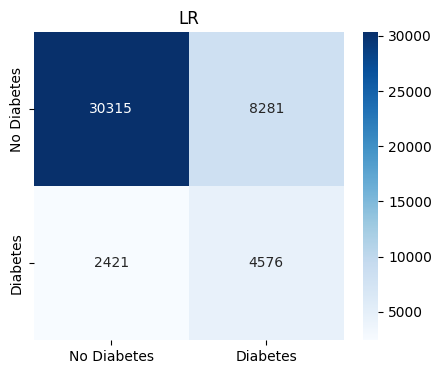

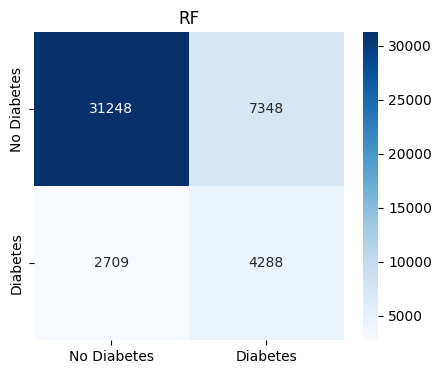

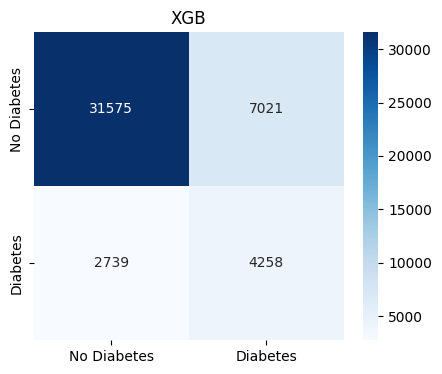

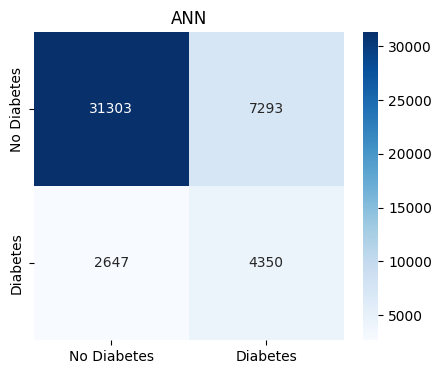

In [ ]:
def plot_cm(cm, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Diabetes", "Diabetes"],
                yticklabels=["No Diabetes", "Diabetes"])
    plt.title(title)
    plt.show()

plot_cm(confusion_matrix(y_test, y_pred_lr), "LR")
plot_cm(confusion_matrix(y_test, y_pred_rf), "RF")
plot_cm(confusion_matrix(y_test, y_pred_xgb), "XGB")
plot_cm(confusion_matrix(y_test, y_pred_ann), "ANN")